# ガウス過程の変数補助法 (Inducing variable method) を実装、比較

In [1]:
using Distributions
using Plots
using LinearAlgebra

In [2]:
include("gp.jl")

fg! (generic function with 1 method)

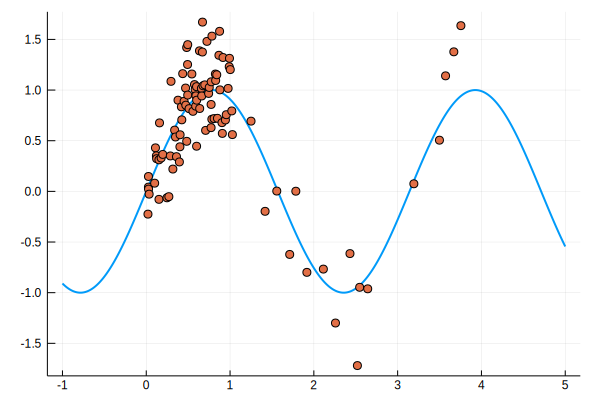

In [3]:
# サンプルデータの作成

xs = vcat(rand(80),rand(20) * 3 .+ 1.0)
sort!(xs)
fx = sin.(xs*2)
ys = fx + rand(Normal(), Base.length(fx)) * 0.3

ts = collect(-1:0.01:5)
plot(ts, sin.(ts*2), lw = 2, label = "")
scatter!(xs, ys, label = "")

## GP

In [4]:
eta = 0.1
gk = GaussianKernel()
gp = GaussianProcess(gk, eta)

GaussianProcess(GPKernel{GaussianKernel}(GaussianKernel(1.0), 0.1), GPStandard())

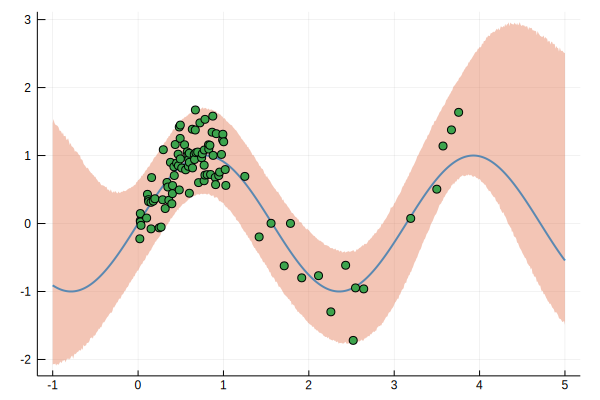

In [5]:
# 一気に全てのテスト入力点を使って予測分布を作成し、
# 予測分布から10000個のサンプルを作成し, 各点の95%信用区間を計算する

dist_gp = predict(gp, xs, ys, ts)

plot(ts, sin.(ts*2), lw = 2, label = "")
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(dist_gp, 10000), dims = 2)
Plots.plot!(ts, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.4,
           label = "", linewidth = 0)

scatter!(xs, ys, label = "")

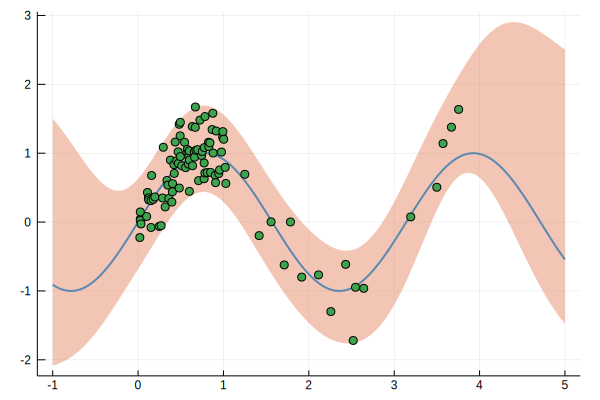

In [6]:
# 各点の分布を計算して信用区間を計算する
# 今後はこちらの方法を採用

function mean_quantile_gp(gp, xs, ys, xtest, p = [0.025, 0.975])
    means = []
    qts = []
    for t in xtest
        dist_gp_t = predict(gp, xs, ys, t)
        push!(means, mean(dist_gp_t))
        push!(qts, quantile.(dist_gp_t, p))
    end

    means, hcat(qts...)
end

_, qt = mean_quantile_gp(gp, xs, ys, ts)

plot(ts, sin.(ts*2), lw = 2, label = "")
Plots.plot!(ts, qt[1, :], fillrange = qt[2, :], fillalpha = 0.4,
           label = "", linewidth = 0)

scatter!(xs, ys, label = "")

点を10個選択して、様々な補助変数方を試す
## The Subset of Data (SoD)

In [7]:
function plot_result(gp_qt, qt, ind_xs, label)
    plot(ts, sin.(ts*2), lw = 2, label = "")
    Plots.plot!(ts, gp_qt[1, :], fillrange = gp_qt[2, :], fillalpha = 0.4,
               label = "GP", linewidth = 0)
    Plots.plot!(ts, qt[1, :], fillrange = qt[2, :], fillalpha = 0.4,
               label = label, linewidth = 0)

    scatter!(xs, ys, label = "")
    scatter!(ind_xs, fill(-2, Base.length(ind_xs)), markershape = :x, label = "")
end

plot_result (generic function with 1 method)

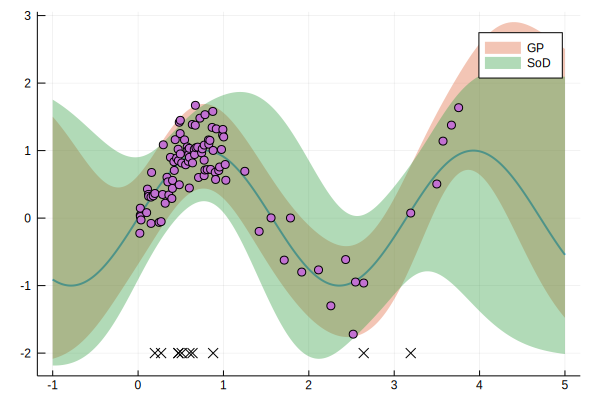

In [8]:
# ランダムに10個点を取る
where_xs = sort(rand(1:Base.length(xs), 10))
sod_xs = xs[where_xs]
sod_ys = ys[where_xs]

_, sod_qt = mean_quantile_gp(gp, sod_xs, sod_ys, ts)

plot_result(qt, sod_qt, sod_xs, "SoD")

## The Subset of Regressors (SoR) Approximation

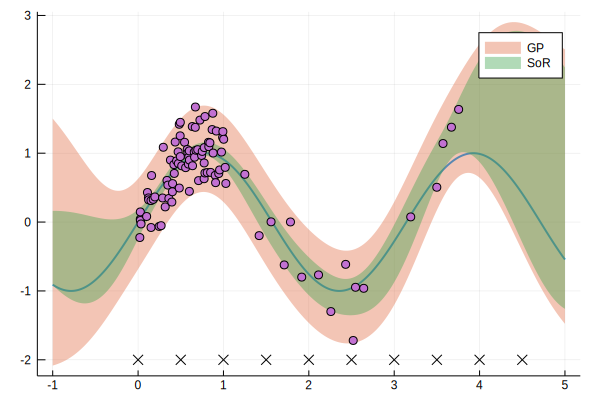

In [9]:
us = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
Kuu = cov(gp, us, us)
Kuf = cov(gp, us, xs)
Kfu = Kuf'
Σ = inv(1 / eta * Kuf * Kfu + Kuu)

function sor(t)
    Kut = cov(gp, us, [t])
    Ktu = Kut'
    
    sor_mu = 1 / eta * Ktu * Σ * Kuf * ys
    sor_cov = Ktu * Σ * Kut

    Normal(sor_mu[1], sqrt(sor_cov[1]))
end

sor_dists = [sor(t) for t in ts]
sor_mean = mean.(sor_dists)
sor_qt = hcat([quantile.(s, [0.025, 0.975]) for s in sor_dists]...)

plot_result(qt, sor_qt, us, "SoR")

## The Subset of Regressors (DTC) Approximation

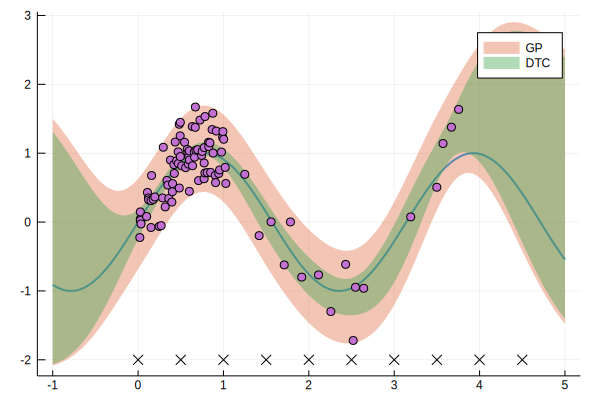

In [10]:
Kuu = cov(gp, us, us)
Kuf = cov(gp, us, xs)
Kfu = Kuf'
Σ = inv(1 / eta * Kuf * Kfu + Kuu)

function dtc(t)
    Kut = cov(gp, us, [t])
    Ktu = Kut'

    Qtt = Ktu * inv(Kuu) * Kut
    Ktt = [ker(gk, t, t)]

    sor_mu = 1 / eta * Ktu * Σ * Kuf * ys
    sor_cov = Ktt - Qtt + Ktu * Σ * Kut

    Normal(sor_mu[1], sqrt(sor_cov[1]))
end

dtc_dists = [dtc(t) for t in ts]
dtc_mean = mean.(dtc_dists)
dtc_qt = hcat([quantile.(s, [0.025, 0.975]) for s in dtc_dists]...)

plot_result(qt, dtc_qt, us, "DTC")

## The Fully Independent Training Conditional (FITC) Approximation

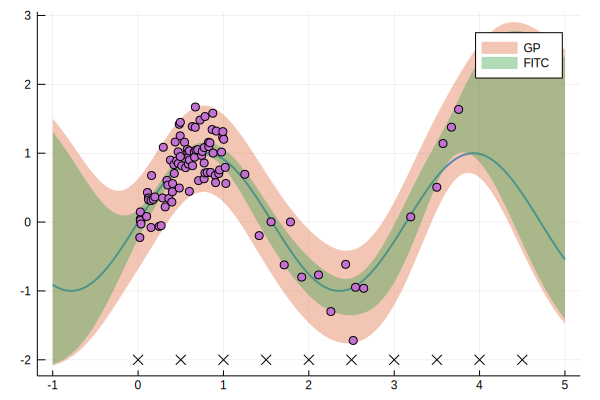

In [11]:
Kuu = cov(gp, us, us)
Kuf = cov(gp, us, xs)
Kfu = Kuf'

Λ = Diagonal([ker(gk, xs[i], xs[i]) - Kfu[i, :]' * inv(Kuu) * Kuf[:, i] + eta 
        for i in 1:Base.length(xs)])
Σ = inv(Kuf * inv(Λ) * Kfu + Kuu)

function fitc(t)
    Kut = cov(gp, us, [t])
    Ktu = Kut'

    Qtt = Ktu * inv(Kuu) * Kut
    Ktt = [ker(gk, t, t)]

    sor_mu = Ktu * Σ * Kuf * inv(Λ) * ys
    sor_cov = Ktt - Qtt + Ktu * Σ * Kut

    Normal(sor_mu[1], sqrt(sor_cov[1]))
end

fitc_dists = [fitc(t) for t in ts]
fitc_mean = mean.(fitc_dists)
fitc_qt = hcat([quantile.(s, [0.025, 0.975]) for s in fitc_dists]...)

plot_result(qt, fitc_qt, us, "FITC")